In [3]:
# Análisis Estadístico: Herramientas Digitales Interactivas en Educación Matemática
# Revisión Sistemática - Población y Metodología

# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
import os
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Descargar recursos de NLTK
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

In [4]:
# === Configuraciones Globales ===
warnings.filterwarnings('ignore') # Suprimir advertencias (usar con precaución)

# Estilo de gráficos Matplotlib/Seaborn
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl") # Paleta de colores
plt.rcParams['figure.figsize'] = (12, 8) # Tamaño de figura por defecto
plt.rcParams['font.size'] = 12 # Tamaño de fuente por defecto

# Constantes
DATA_FILE = 'poblacionMetodologia.csv'
OUTPUT_DIR = 'output_plots' # Directorio para guardar gráficos
MISSING_THRESHOLD = 0.5 # Umbral para considerar alta proporción de datos faltantes

# Crear directorio de salida si no existe
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# === Descarga de Recursos NLTK ===
# Se descargan de forma silenciosa si no están presentes
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    print("Recursos NLTK listos.")
except Exception as e:
    print(f"Error descargando recursos NLTK: {e}")
    print("El análisis de texto puede fallar si los recursos no están disponibles.")


Recursos NLTK listos.


In [5]:
# %% [markdown]
# ## 1. Funciones Auxiliares
# Definición de funciones reutilizables para limpieza, extracción y análisis.

# %%
# === Funciones de Procesamiento de Datos ===

def extract_sample_size(text):
    """Extrae el primer número encontrado en el texto como tamaño de muestra."""
    if pd.isna(text):
        return np.nan
    # Busca uno o más dígitos
    numbers = re.findall(r'\d+', str(text))
    if numbers:
        # Devuelve el primer número encontrado como entero
        return int(numbers[0])
    return np.nan

def analyze_sentiment(text, positive_words, negative_words):
    """Realiza un análisis de sentimiento simple basado en palabras clave."""
    if pd.isna(text):
        return 'neutral' # O 'unknown' si se prefiere
    text_lower = str(text).lower()
    pos_count = sum(1 for word in positive_words if word in text_lower)
    neg_count = sum(1 for word in negative_words if word in text_lower)

    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

def classify_age_group(text, age_patterns):
    """Clasifica el grupo de edad basado en patrones regex."""
    if pd.isna(text):
        return 'Unknown'
    text_lower = str(text).lower()
    for group, pattern in age_patterns.items():
        # re.search busca el patrón en cualquier parte del texto
        if re.search(pattern, text_lower):
            return group
    return 'Unknown' # Si no coincide con ningún patrón

def categorize_tool(text, tool_categories):
    """Categoriza las herramientas digitales mencionadas en el texto."""
    if pd.isna(text):
        return ['Otros'] # Devuelve una lista, consistente con múltiples categorías
    text_lower = str(text).lower()
    categories = []
    for category, keywords in tool_categories.items():
        # any() verifica si alguna palabra clave está presente
        if any(keyword in text_lower for keyword in keywords):
            categories.append(category)
    # Si no se encontró ninguna categoría específica, clasificar como 'Otros'
    return categories if categories else ['Otros']

def extract_instruments(text):
    """Extrae tipos comunes de instrumentos de evaluación de un texto."""
    instruments = []
    if pd.isna(text):
        return instruments
    text_lower = str(text).lower()
    # Patrones para identificar tipos de instrumentos (usando \b para palabra completa)
    patterns = [
        r'test\b', r'scale\b', r'questionnaire\b', r'survey\b',
        r'assessment\b', r'inventory\b', r'measure\b', r'interview\b',
        r'observation\b', r'rubric\b' # Añadidos algunos comunes
    ]
    for pattern in patterns:
        matches = re.findall(pattern, text_lower)
        instruments.extend(matches)
    # Devuelve tipos únicos si es necesario, o todos los encontrados
    return instruments # O list(set(instruments)) para únicos

In [6]:
# === Funciones de Visualización ===

def add_labels_to_bars(bars, ax, orientation='vertical', format_str='{:.0f}', **kwargs):
    """Añade etiquetas de valor a las barras de un gráfico."""
    for bar in bars:
        if orientation == 'vertical':
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    format_str.format(height),
                    ha='center', va='bottom', **kwargs)
        elif orientation == 'horizontal':
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2.,
                    format_str.format(width),
                    ha='left', va='center', **kwargs)

def save_plot(fig, filename, output_dir=OUTPUT_DIR, dpi=300):
    """Guarda la figura en el directorio especificado."""
    filepath = os.path.join(output_dir, filename)
    try:
        fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
        print(f"✓ Gráfico guardado en: {filepath}")
    except Exception as e:
        print(f"Error al guardar gráfico {filepath}: {e}")

# %% [markdown]
# ## 2. Carga y Exploración Inicial de Datos
# Carga del dataset y revisión básica de su estructura y contenido.

# %%
# === Carga de Datos ===
try:
    df = pd.read_csv(DATA_FILE, sep=';', encoding='utf-8')
    print(f"Dataset '{DATA_FILE}' cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: El archivo '{DATA_FILE}' no se encontró.")
    # Detener la ejecución o manejar el error según sea necesario
    raise SystemExit(f"Archivo {DATA_FILE} no encontrado.")

Dataset 'poblacionMetodologia.csv' cargado exitosamente.


In [7]:
# === Información Básica ===
print("\n" + "="*60)
print(" ANÁLISIS ESTADÍSTICO: HERRAMIENTAS DIGITALES EN MATEMÁTICAS")
print("="*60)
print(f"\nNúmero total de estudios: {len(df)}")
print(f"Número de variables (columnas): {len(df.columns)}")
print(f"Columnas: {', '.join(df.columns)}")
if 'Year' in df.columns:
     print(f"Período temporal de los estudios: {df['Year'].min()} - {df['Year'].max()}")
else:
     print("Columna 'Year' no encontrada para determinar el período.")

# Mostrar las primeras filas
print("\nPrimeras 5 filas del dataset:")
print(df.head())

# Tipos de datos
print("\nTipos de datos por columna:")
print(df.info())

# === Análisis de Datos Faltantes ===
print("\nAnálisis de Datos Faltantes:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_data, 'Percentage': missing_percent})
# Mostrar solo columnas con datos faltantes, ordenadas por porcentaje
missing_df = missing_df[missing_df['Count'] > 0].sort_values(by='Percentage', ascending=False)

if not missing_df.empty:
    print(missing_df)
    # Advertir sobre columnas con alto porcentaje de faltantes
    high_missing = missing_df[missing_df['Percentage'] > (MISSING_THRESHOLD * 100)]
    if not high_missing.empty:
        print(f"\nAdvertencia: Las siguientes columnas tienen más del {MISSING_THRESHOLD*100:.0f}% de datos faltantes:")
        print(high_missing.index.tolist())
else:
    print("No se encontraron datos faltantes en el dataset.")

# %% [markdown]
# ## 3. Preprocesamiento y Creación de Nuevas Variables
# Aplicación de las funciones auxiliares para extraer y transformar datos.

# %%
# === Extracción de Tamaño de Muestra ===
if 'Sample Size' in df.columns:
    df['Sample_Size_Numeric'] = df['Sample Size'].apply(extract_sample_size)
    print("\nColumna 'Sample_Size_Numeric' creada.")
    # Considerar imputación si hay muchos NaNs y se usará en modelos
    median_sample_size = df['Sample_Size_Numeric'].median()
    # df['Sample_Size_Numeric'].fillna(median_sample_size, inplace=True) # Ejemplo de imputación (usar con cuidado)
else:
    print("Advertencia: Columna 'Sample Size' no encontrada. No se pudo extraer tamaño de muestra numérico.")

# === Análisis de Sentimiento ===
if 'General Results' in df.columns:
    # Palabras clave para sentimiento (ajustar según contexto)
    positive_words = ['improved', 'significant', 'positive', 'better', 'effective', 'success', 'enhanced', 'increased', 'benefit', 'gain']
    negative_words = ['decreased', 'negative', 'worse', 'failed', 'poor', 'difficult', 'problem', 'challenge', 'barrier', 'no effect', 'not significant']
    df['Sentiment'] = df['General Results'].apply(lambda x: analyze_sentiment(x, positive_words, negative_words))
    print("Columna 'Sentiment' creada basada en resultados generales.")
else:
     print("Advertencia: Columna 'General Results' no encontrada. No se pudo realizar análisis de sentimiento.")

# === Clasificación por Grupo de Edad ===
if 'Age/Grade' in df.columns:
    # Patrones Regex para grupos de edad (ajustar según necesidad)
    age_patterns = {
        'primary': r'primary|elementary|grade [1-6]\b|ages? [6-9](?:-1[0-2])?|key stage [1-2]',
        'middle': r'middle|secondary|junior high|grade [7-9]\b|ages? 1[0-4]',
        'high': r'high school|senior high|grade (?:1[0-2]|[1-9]th)|ages? 1[5-8]',
        'higher_education': r'university|college|undergraduate|postgraduate|tertiary',
        'mixed': r'mixed|various|all grades|k-12|different levels',
        'teacher': r'teacher|educator|instructor|pre-service' # Grupo específico para profesores
    }
    df['Age_Group'] = df['Age/Grade'].apply(lambda x: classify_age_group(x, age_patterns))
    print("Columna 'Age_Group' creada.")
else:
    print("Advertencia: Columna 'Age/Grade' no encontrada. No se pudo clasificar por grupo de edad.")

# === Categorización de Herramientas Digitales ===
if 'Intervention' in df.columns:
    # Categorías y palabras clave para herramientas (ajustar/expandir)
    tool_categories = {
        'Software Educativo': ['software', 'program', 'platform', 'application', 'app', 'tool', 'system'],
        'Juegos/Gamificación': ['game', 'gamification', 'gamified', 'serious game'],
        'AR/VR/3D': ['augmented reality', 'virtual reality', 'ar', 'vr', '3d', 'immersive'],
        'Pizarras Interactivas': ['interactive whiteboard', 'smartboard', 'iwb'],
        'Plataformas Adaptativas/ITS': ['adaptive', 'personalized', 'intelligent tutor', 'its', 'learning system'],
        'Móviles/Tabletas': ['mobile', 'tablet', 'smartphone', 'ipad'],
        'Robótica': ['robot', 'robotics'],
        'Calculadoras/Graficadores': ['calculator', 'graphing calculator', 'desmos', 'geogebra'], # Geogebra podría ser software también
        'Simulaciones/Modelado': ['simulation', 'model', 'virtual lab']
    }
    df['Tool_Categories'] = df['Intervention'].apply(lambda x: categorize_tool(x, tool_categories))
    print("Columna 'Tool_Categories' creada.")
else:
    print("Advertencia: Columna 'Intervention' no encontrada. No se pudo categorizar herramientas.")

# Mostrar DataFrame con nuevas columnas
print("\nDataFrame con nuevas columnas creadas:")
new_cols = ['Sample_Size_Numeric', 'Sentiment', 'Age_Group', 'Tool_Categories']
cols_to_show = [col for col in new_cols if col in df.columns]
if cols_to_show:
    print(df[cols_to_show].head())


 ANÁLISIS ESTADÍSTICO: HERRAMIENTAS DIGITALES EN MATEMÁTICAS

Número total de estudios: 29
Número de variables (columnas): 17
Columnas: Authors, Year, Country, Sample Size, Age/Grade, Special Characteristics, Study Design, Intervention, Control/Comparison, Setting, Cognitive Instruments, Affective Instruments, Other Instruments, Quantitative Methods, Qualitative Methods, Mixed Methods, General Results
Período temporal de los estudios: 2020 - 2025

Primeras 5 filas del dataset:
                                             Authors  Year  \
0                          Norbert Annuš, Tibor Kmeť  2024   
1  Lida Asencios-Trujillo, Lucia Asencios-Trujill...  2024   
2    Luca Cerniglia, Silvia Cimino, Massimo Ammaniti  2021   
3  Buentello-Montoya, D.A., Lomelí-Plascencia, M....  2021   
4      Chen, I.H., Gamble, J.H., Lee, Z.H., Fu, Q.L.  2020   

                                             Country  \
0                                           Slovakia   
1                               

✓ Gráfico guardado en: output_plots\distribucion_temporal.png


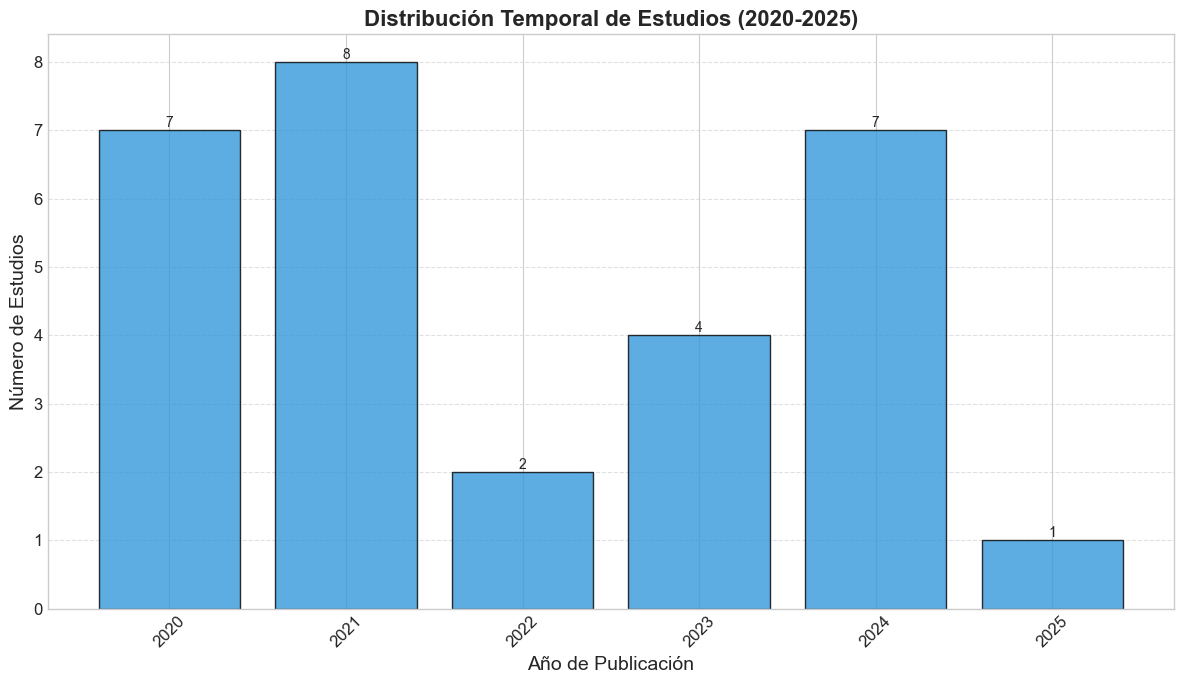

✓ Gráfico guardado en: output_plots\distribucion_geografica.png


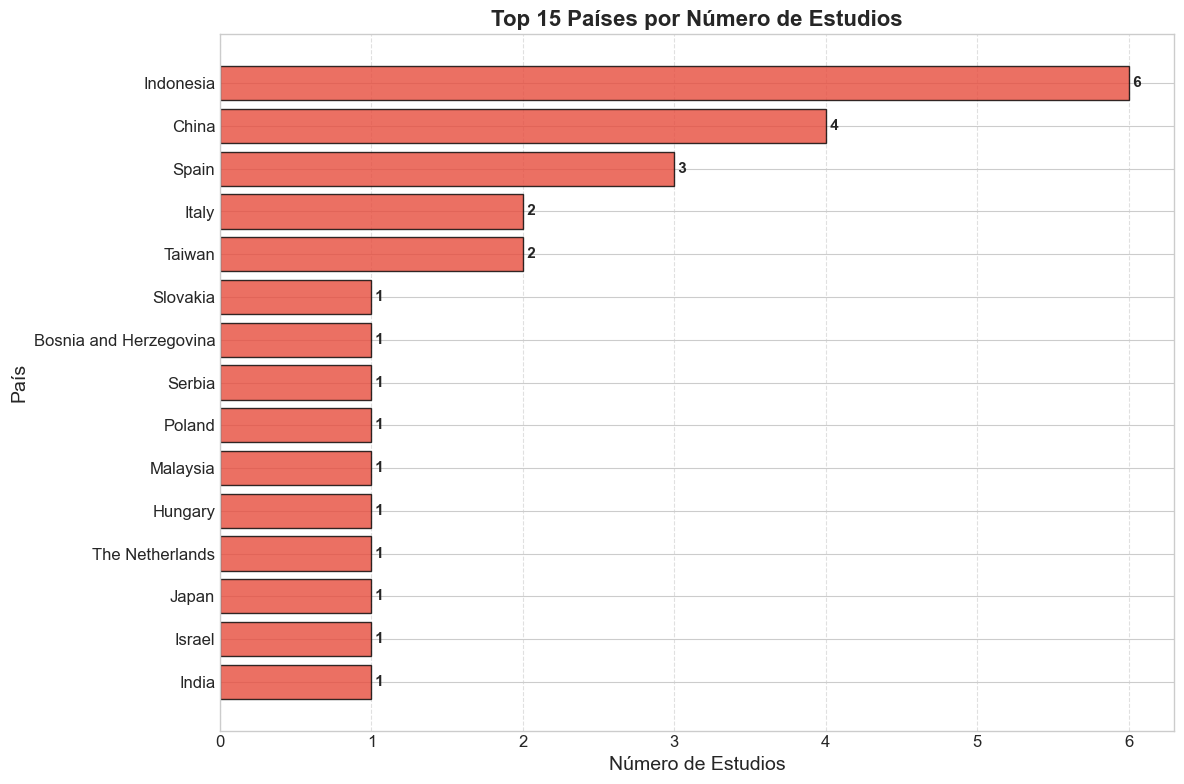


Estadísticas Descriptivas del Tamaño de Muestra:
count      29.000000
mean      298.758621
std       911.486096
min         2.000000
25%        31.000000
50%       116.000000
75%       200.000000
max      5000.000000
Name: Sample_Size_Numeric, dtype: float64
✓ Gráfico guardado en: output_plots\distribucion_muestra.png


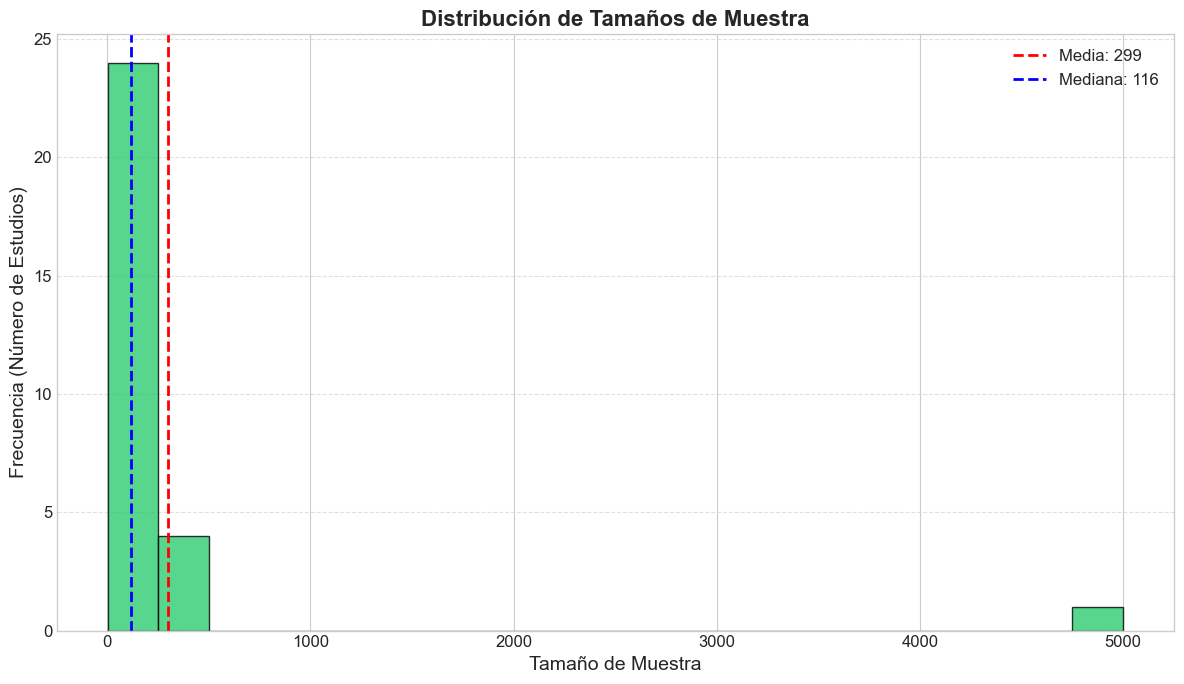

✓ Gráfico guardado en: output_plots\distribucion_disenos.png


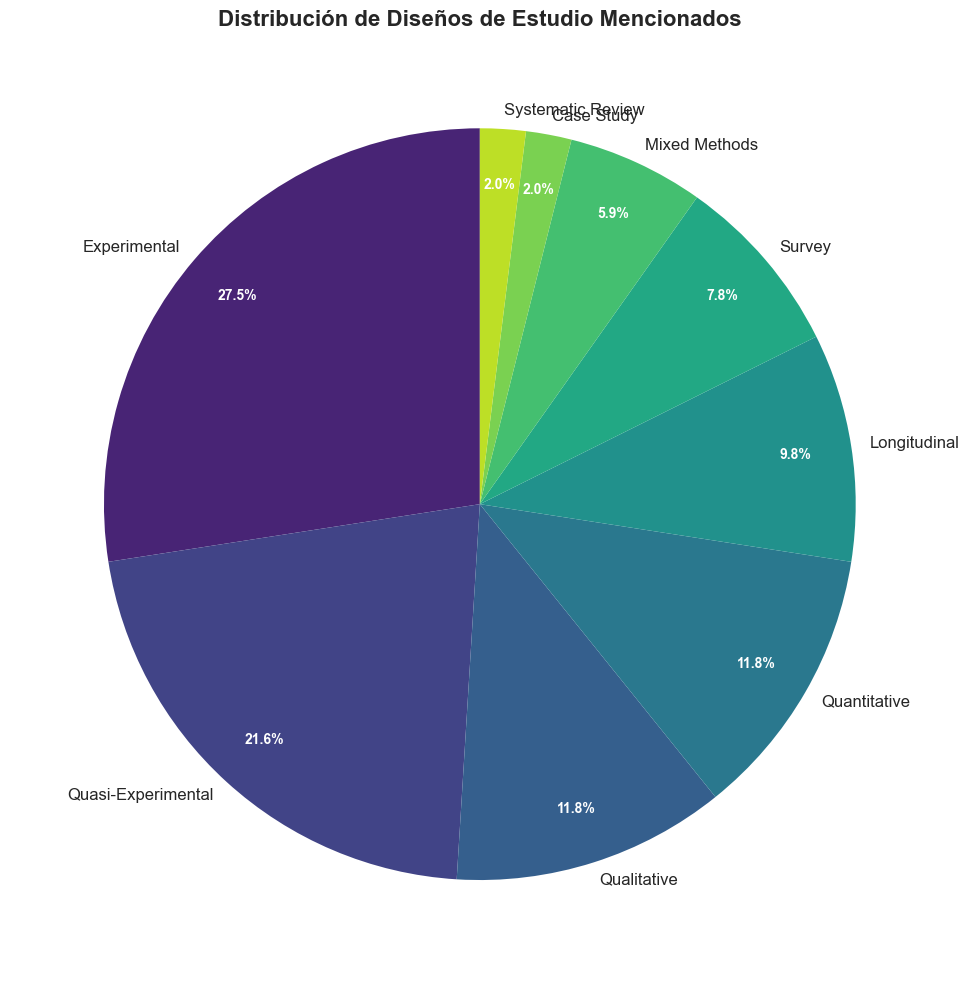

In [8]:
# %% [markdown]
# ## 4. Análisis Descriptivo Univariado
# Visualización de las distribuciones de variables clave.

# %% [markdown]
# ### 4.1 Distribución Temporal de Estudios

# %%
if 'Year' in df.columns:
    plt.figure(figsize=(12, 7))
    year_counts = df['Year'].value_counts().sort_index()
    bars = plt.bar(year_counts.index.astype(str), year_counts.values, color='#3498db', edgecolor='black', alpha=0.8)
    plt.title(f'Distribución Temporal de Estudios ({df["Year"].min()}-{df["Year"].max()})', fontsize=16, fontweight='bold')
    plt.xlabel('Año de Publicación', fontsize=14)
    plt.ylabel('Número de Estudios', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Añadir etiquetas a las barras
    add_labels_to_bars(bars, plt.gca(), format_str='{:.0f}', fontsize=10)

    plt.tight_layout()
    save_plot(plt.gcf(), 'distribucion_temporal.png')
    plt.show()
else:
    print("No se puede generar gráfico temporal: Falta la columna 'Year'.")


# %% [markdown]
# ### 4.2 Distribución Geográfica

# %%
if 'Country' in df.columns:
    # Separar países si hay múltiples por estudio, limpiar espacios y contar
    country_data = df['Country'].str.split(',').explode().str.strip().dropna()
    country_counts = country_data.value_counts()

    # Visualizar Top N países
    top_n = 15
    top_countries = country_counts.head(top_n)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_countries.index[::-1], top_countries.values[::-1], color='#e74c3c', alpha=0.8, edgecolor='black')
    plt.title(f'Top {top_n} Países por Número de Estudios', fontsize=16, fontweight='bold')
    plt.xlabel('Número de Estudios', fontsize=14)
    plt.ylabel('País', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Añadir etiquetas a las barras horizontales
    add_labels_to_bars(bars, plt.gca(), orientation='horizontal', format_str=' {:.0f}', fontsize=11, fontweight='bold')

    plt.tight_layout()
    save_plot(plt.gcf(), 'distribucion_geografica.png')
    plt.show()
else:
    print("No se puede generar gráfico geográfico: Falta la columna 'Country'.")

# %% [markdown]
# ### 4.3 Distribución del Tamaño de Muestra

# %%
if 'Sample_Size_Numeric' in df.columns:
    sample_data = df['Sample_Size_Numeric'].dropna()
    if not sample_data.empty:
        sample_stats = sample_data.describe()
        print("\nEstadísticas Descriptivas del Tamaño de Muestra:")
        print(sample_stats)

        plt.figure(figsize=(12, 7))
        # Usar un número de bins adecuado o Freedman-Diaconis rule
        plt.hist(sample_data, bins=20, color='#2ecc71', edgecolor='black', alpha=0.8)
        plt.title('Distribución de Tamaños de Muestra', fontsize=16, fontweight='bold')
        plt.xlabel('Tamaño de Muestra', fontsize=14)
        plt.ylabel('Frecuencia (Número de Estudios)', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Añadir líneas de media y mediana
        mean_val = sample_stats['mean']
        median_val = sample_stats['50%']
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.0f}')
        plt.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.0f}')

        plt.legend()
        plt.tight_layout()
        save_plot(plt.gcf(), 'distribucion_muestra.png')
        plt.show()
    else:
        print("No hay datos numéricos de tamaño de muestra para graficar.")
else:
    print("No se puede generar gráfico de tamaño de muestra: Falta la columna 'Sample_Size_Numeric'.")

# %% [markdown]
# ### 4.4 Distribución de Diseños de Estudio

# %%
if 'Study Design' in df.columns:
    # Identificar diseños mencionados (simplificado, puede necesitar ajuste)
    design_patterns = {
        'Experimental': 'experimental',
        'Quasi-Experimental': 'quasi-experimental',
        'Mixed Methods': 'mixed method', # 'mixed methods'
        'Qualitative': 'qualitative',
        'Quantitative': 'quantitative',
        'Case Study': 'case study',
        'Longitudinal': 'longitudinal',
        'Systematic Review': 'systematic review|meta-analysis',
        'Survey': 'survey'
        # Añadir otros si es necesario
    }
    design_counts = {}
    design_col = df['Study Design'].str.lower().fillna('')

    for name, pattern in design_patterns.items():
        # Cuenta estudios donde el patrón aparece
        count = design_col.str.contains(pattern, regex=True).sum()
        if count > 0:
            design_counts[name] = count
        # Considerar que un estudio puede mencionar múltiples diseños

    # Convertir a Series para facilitar el gráfico
    design_series = pd.Series(design_counts).sort_values(ascending=False)

    if not design_series.empty:
        plt.figure(figsize=(10, 10)) # Aumentar tamaño para gráfico de tarta
        # Usar una paleta de colores agradable
        colors = sns.color_palette("viridis", len(design_series))
        # Gráfico de Tarta (alternativa: gráfico de barras)
        wedges, texts, autotexts = plt.pie(design_series.values, labels=design_series.index,
                                           autopct='%1.1f%%', colors=colors, startangle=90,
                                           pctdistance=0.85, labeldistance=1.05)
        # Mejorar legibilidad
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_weight('bold')
            autotext.set_fontsize(10)
        for text in texts:
            text.set_fontsize(12)

        plt.title('Distribución de Diseños de Estudio Mencionados', fontsize=16, fontweight='bold')
        # Centro del círculo para efecto donut (opcional)
        # centre_circle = plt.Circle((0,0),0.70,fc='white')
        # fig = plt.gcf()
        # fig.gca().add_artist(centre_circle)

        plt.tight_layout()
        save_plot(plt.gcf(), 'distribucion_disenos.png')
        plt.show()
    else:
        print("No se pudieron identificar diseños de estudio comunes.")
else:
    print("No se puede analizar diseños de estudio: Falta la columna 'Study Design'.")

✓ Gráfico guardado en: output_plots\distribucion_grupos_edad.png


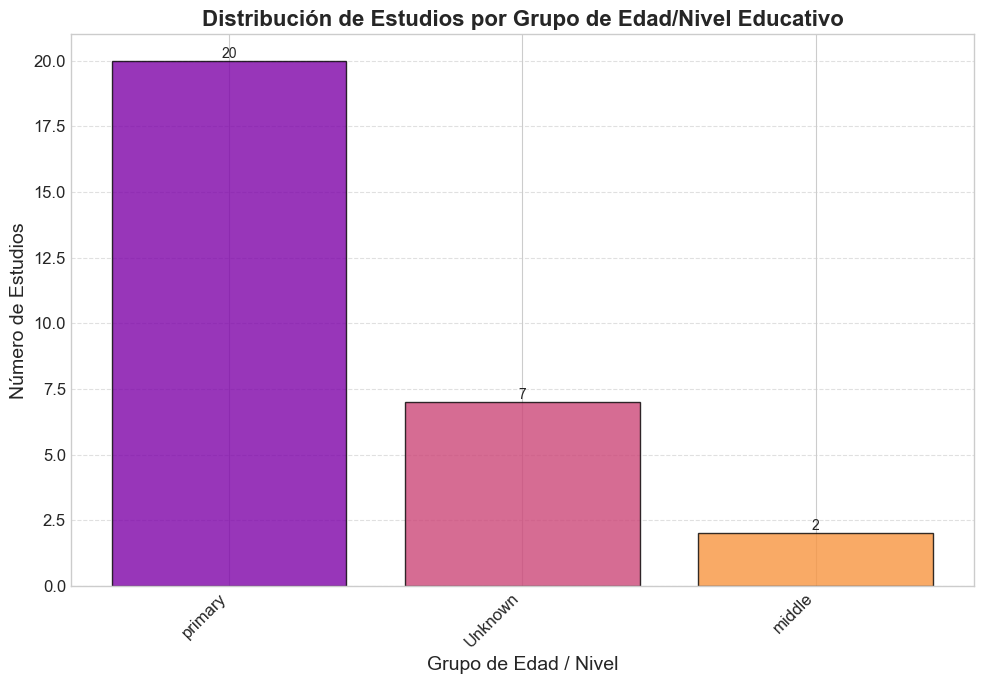

✓ Gráfico guardado en: output_plots\distribucion_tipos_herramientas.png


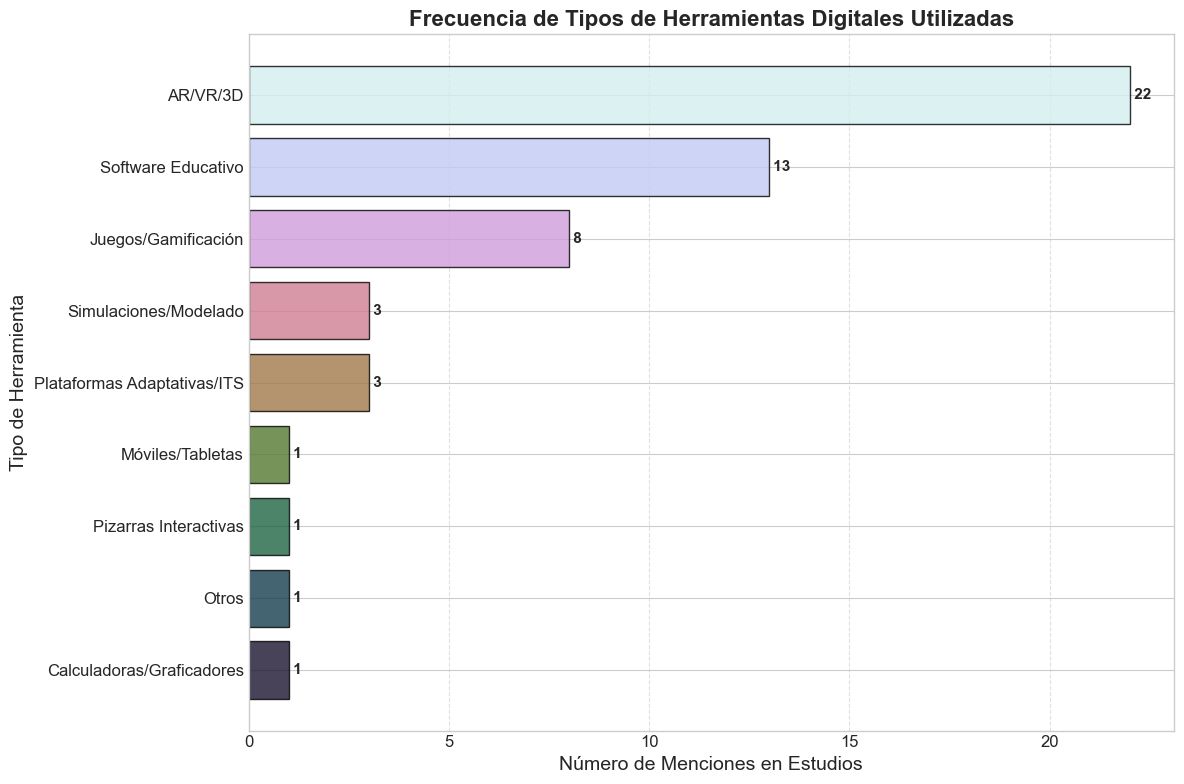

✓ Gráfico guardado en: output_plots\instrumentos_evaluacion.png


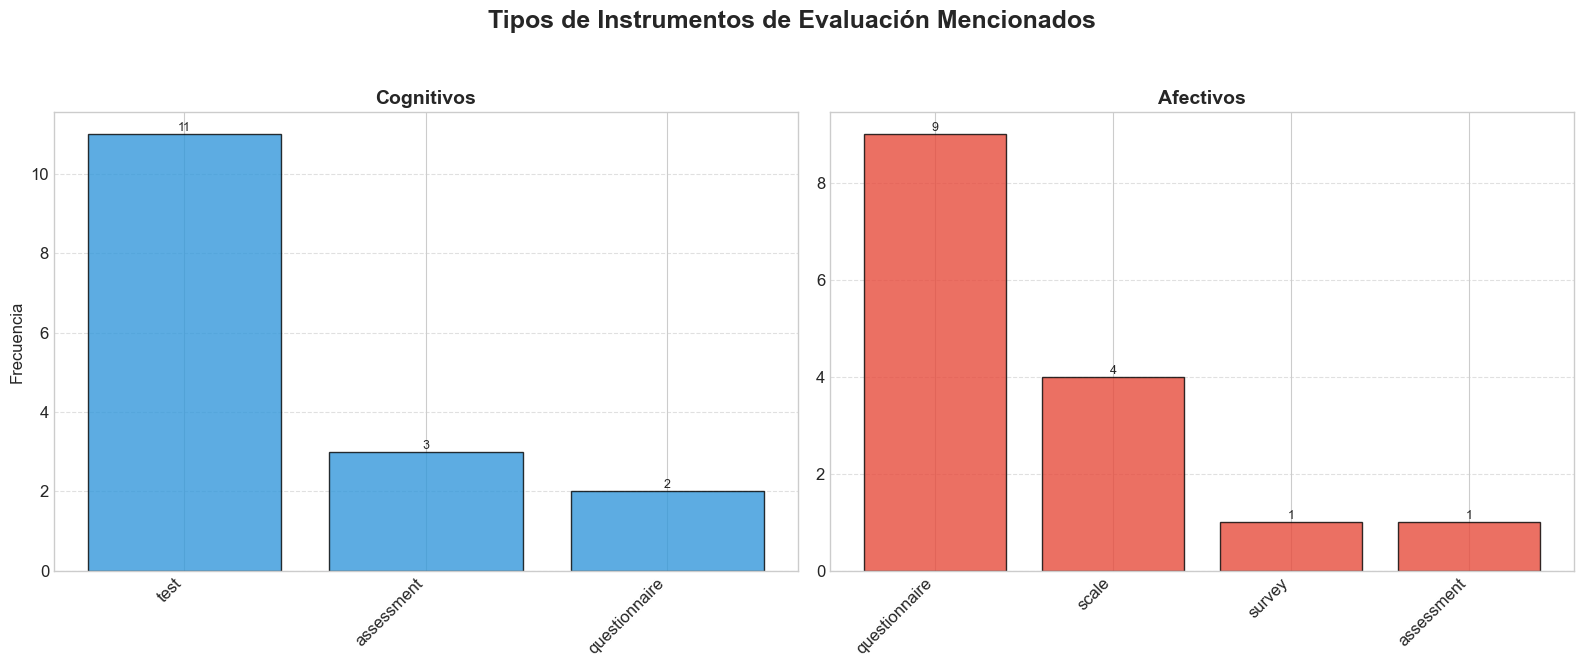

In [11]:
# %% [markdown]
# ### 4.5 Distribución por Grupos de Edad

# %%
if 'Age_Group' in df.columns:
    age_group_counts = df['Age_Group'].value_counts()

    if not age_group_counts.empty:
        plt.figure(figsize=(10, 7))
        colors = sns.color_palette("plasma", len(age_group_counts))
        bars = plt.bar(age_group_counts.index, age_group_counts.values, color=colors, alpha=0.8, edgecolor='black')
        plt.title('Distribución de Estudios por Grupo de Edad/Nivel Educativo', fontsize=16, fontweight='bold')
        plt.xlabel('Grupo de Edad / Nivel', fontsize=14)
        plt.ylabel('Número de Estudios', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        add_labels_to_bars(bars, plt.gca(), format_str='{:.0f}', fontsize=10)

        plt.tight_layout()
        save_plot(plt.gcf(), 'distribucion_grupos_edad.png')
        plt.show()
    else:
        print("No hay datos de grupo de edad para graficar.")
else:
    print("No se puede generar gráfico de grupos de edad: Falta la columna 'Age_Group'.")

# %% [markdown]
# ### 4.6 Distribución de Tipos de Herramientas Digitales

# %%
if 'Tool_Categories' in df.columns:
    # 'explode' para manejar estudios con múltiples categorías
    all_categories = df['Tool_Categories'].explode()
    tool_counts = all_categories.value_counts()

    if not tool_counts.empty:
        plt.figure(figsize=(12, 8)) # Gráfico de barras es a menudo mejor que tarta para muchas categorías
        colors = sns.color_palette("cubehelix", len(tool_counts))
        bars = plt.barh(tool_counts.index[::-1], tool_counts.values[::-1], color=colors, alpha=0.8, edgecolor='black')
        plt.title('Frecuencia de Tipos de Herramientas Digitales Utilizadas', fontsize=16, fontweight='bold')
        plt.xlabel('Número de Menciones en Estudios', fontsize=14)
        plt.ylabel('Tipo de Herramienta', fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.6)

        add_labels_to_bars(bars, plt.gca(), orientation='horizontal', format_str=' {:.0f}', fontsize=11, fontweight='bold')

        plt.tight_layout()
        save_plot(plt.gcf(), 'distribucion_tipos_herramientas.png')
        plt.show()
    else:
        print("No hay datos de categorías de herramientas para graficar.")
else:
    print("No se puede generar gráfico de tipos de herramientas: Falta la columna 'Tool_Categories'.")

# %% [markdown]
# ### 4.7 Distribución de Tipos de Instrumentos de Evaluación

# %%
if 'Cognitive Instruments' in df.columns or 'Affective Instruments' in df.columns:
    cognitive_instruments = df['Cognitive Instruments'].dropna() if 'Cognitive Instruments' in df.columns else pd.Series(dtype=str)
    affective_instruments = df['Affective Instruments'].dropna() if 'Affective Instruments' in df.columns else pd.Series(dtype=str)

    cognitive_types = []
    affective_types = []

    for inst_text in cognitive_instruments:
        cognitive_types.extend(extract_instruments(inst_text))
    for inst_text in affective_instruments:
        affective_types.extend(extract_instruments(inst_text))

    cog_counts = pd.Series(cognitive_types).value_counts()
    aff_counts = pd.Series(affective_types).value_counts()

    # Visualizar si hay datos
    if not cog_counts.empty or not aff_counts.empty:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False) # Compartir Y puede no ser ideal si escalas difieren mucho
        fig.suptitle('Tipos de Instrumentos de Evaluación Mencionados', fontsize=18, fontweight='bold')

        # Instrumentos Cognitivos
        if not cog_counts.empty:
            ax1 = axes[0]
            bars1 = ax1.bar(cog_counts.index, cog_counts.values, color='#3498db', alpha=0.8, edgecolor='black')
            ax1.set_title('Cognitivos', fontsize=14, fontweight='bold')
            ax1.set_ylabel('Frecuencia', fontsize=12)
            # Suponiendo que ax1 es tu objeto Axes
            plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
            #ax1.tick_params(axis='x', rotation=45, ha='right')
            ax1.grid(axis='y', linestyle='--', alpha=0.6)
            add_labels_to_bars(bars1, ax1, format_str='{:.0f}', fontsize=9)
        else:
             axes[0].set_title('Cognitivos (Sin Datos)', fontsize=14)
             axes[0].text(0.5, 0.5, 'No se encontraron\ninstrumentos cognitivos', ha='center', va='center', fontsize=12, color='grey')
             axes[0].set_xticks([])
             axes[0].set_yticks([])


        # Instrumentos Afectivos
        if not aff_counts.empty:
            ax2 = axes[1]
            bars2 = ax2.bar(aff_counts.index, aff_counts.values, color='#e74c3c', alpha=0.8, edgecolor='black')
            ax2.set_title('Afectivos', fontsize=14, fontweight='bold')
            # ax2.set_ylabel('Frecuencia', fontsize=12) # Ya está en el primero si comparten Y
            # Suponiendo que ax1 es tu objeto Axes
            plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
            #ax2.tick_params(axis='x', rotation=45, ha='right')
            ax2.grid(axis='y', linestyle='--', alpha=0.6)
            add_labels_to_bars(bars2, ax2, format_str='{:.0f}', fontsize=9)
        else:
             axes[1].set_title('Afectivos (Sin Datos)', fontsize=14)
             axes[1].text(0.5, 0.5, 'No se encontraron\ninstrumentos afectivos', ha='center', va='center', fontsize=12, color='grey')
             axes[1].set_xticks([])
             axes[1].set_yticks([])


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el supertítulo
        save_plot(fig, 'instrumentos_evaluacion.png')
        plt.show()
    else:
        print("No se encontraron menciones de instrumentos cognitivos ni afectivos.")

else:
    print("No se pueden analizar instrumentos: Faltan las columnas 'Cognitive Instruments' y/o 'Affective Instruments'.")



✓ Gráfico guardado en: output_plots\terminos_frecuentes_intervenciones.png


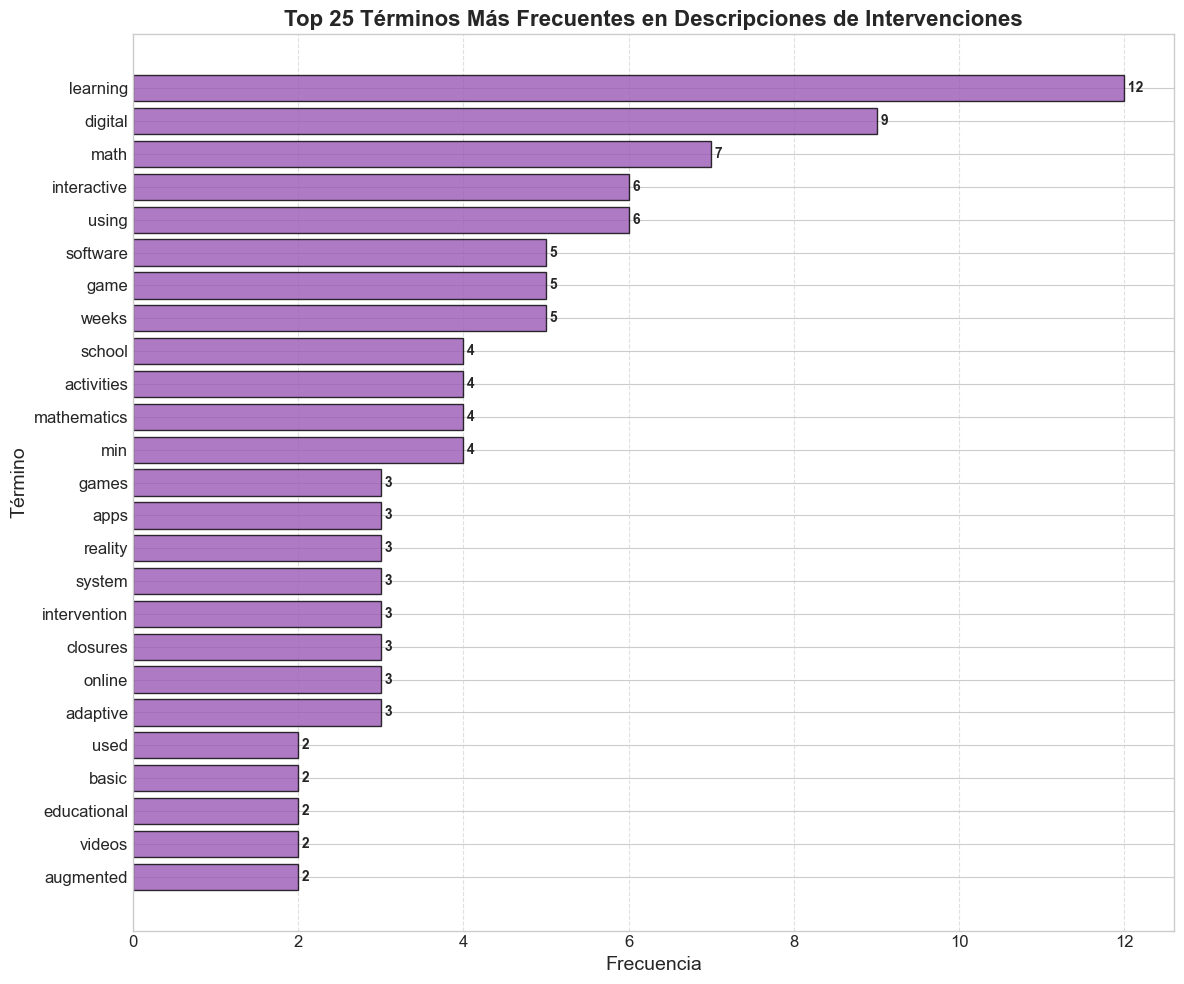

✓ Gráfico guardado en: output_plots\wordcloud_intervenciones.png


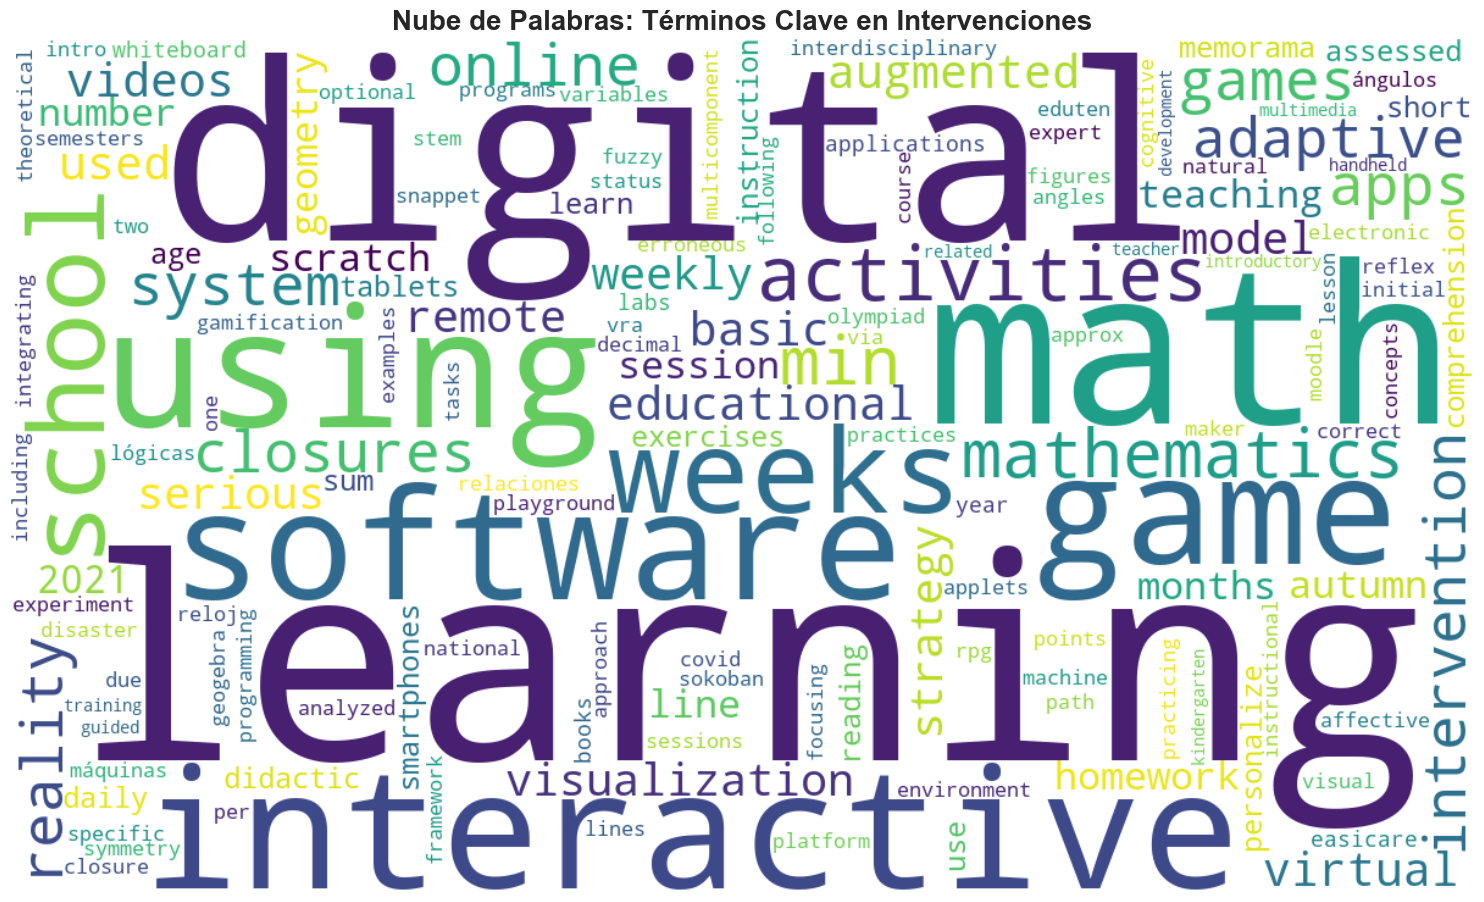

In [12]:
# %% [markdown]
# ## 5. Análisis de Texto de las Intervenciones (NLP Básico)
# Exploración de los términos más frecuentes en la descripción de las intervenciones.

# %%
if 'Intervention' in df.columns:
    # Combinar todo el texto de intervenciones, manejar NaNs
    interventions_text = ' '.join(df['Intervention'].dropna().astype(str))

    if interventions_text.strip(): # Proceder solo si hay texto
        # Tokenización y limpieza básica
        intervention_words = word_tokenize(interventions_text.lower())
        # Usar stopwords en inglés, añadir personalizadas si es necesario
        stop_words = set(stopwords.words('english'))
        # stop_words.update(['study', 'tool', 'students', 'learning', 'use', 'based', 'activity', 'activities']) # Ejemplo de personalización
        # Filtrar palabras (alfanuméricas y no stopwords)
        filtered_words = [word for word in intervention_words if word.isalnum() and word not in stop_words and len(word) > 2] # Añadir filtro de longitud mínima

        # Calcular frecuencia de palabras
        word_freq = Counter(filtered_words)
        top_n_words = 25
        common_words_df = pd.DataFrame(word_freq.most_common(top_n_words), columns=['Termino', 'Frecuencia'])

        # Visualización de términos frecuentes
        plt.figure(figsize=(12, 10))
        bars = plt.barh(common_words_df['Termino'][::-1], common_words_df['Frecuencia'][::-1], color='#9b59b6', alpha=0.8, edgecolor='black')
        plt.title(f'Top {top_n_words} Términos Más Frecuentes en Descripciones de Intervenciones', fontsize=16, fontweight='bold')
        plt.xlabel('Frecuencia', fontsize=14)
        plt.ylabel('Término', fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        add_labels_to_bars(bars, plt.gca(), orientation='horizontal', format_str=' {:.0f}', fontsize=10, fontweight='bold')
        plt.tight_layout()
        save_plot(plt.gcf(), 'terminos_frecuentes_intervenciones.png')
        plt.show()

        # Nube de Palabras
        if word_freq: # Generar solo si hay frecuencias
            plt.figure(figsize=(15, 10))
            # Ajustar parámetros de WordCloud según sea necesario
            wordcloud = WordCloud(width=1200, height=700, background_color='white',
                                  colormap='viridis', max_words=150, contour_color='steelblue',
                                  contour_width=1, random_state=42).generate_from_frequencies(word_freq)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off') # Ocultar ejes
            plt.title('Nube de Palabras: Términos Clave en Intervenciones', fontsize=20, fontweight='bold')
            plt.tight_layout()
            save_plot(plt.gcf(), 'wordcloud_intervenciones.png')
            plt.show()
        else:
            print("No se generó nube de palabras: No se encontraron términos frecuentes tras el filtrado.")

    else:
        print("No hay texto en la columna 'Intervention' para analizar.")
else:
    print("No se puede realizar análisis de texto: Falta la columna 'Intervention'.")



✓ Gráfico guardado en: output_plots\distribucion_sentimiento_resultados.png


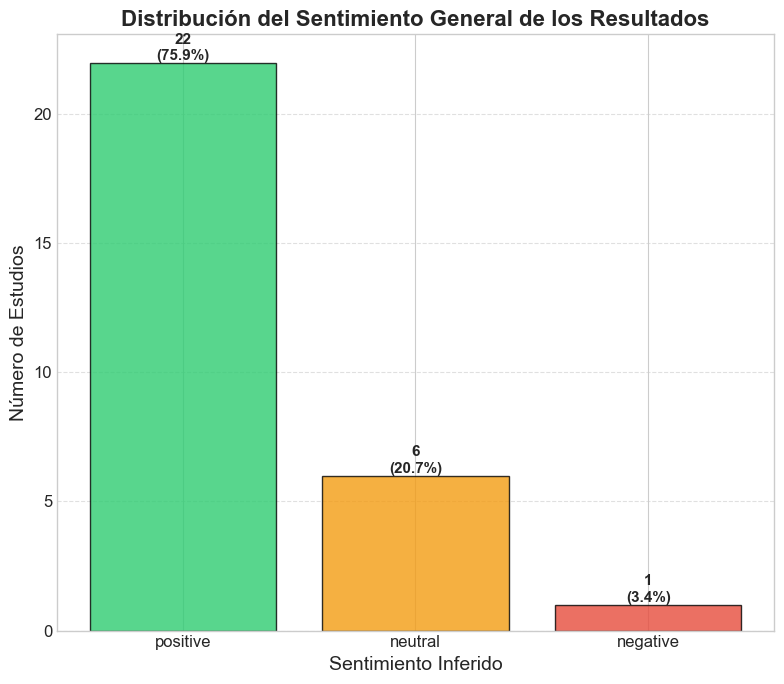

In [13]:
# %% [markdown]
# ## 6. Análisis de Resultados y Sentimiento
# Evaluación de la tendencia general de los resultados reportados.

# %%
if 'Sentiment' in df.columns:
    sentiment_counts = df['Sentiment'].value_counts()

    if not sentiment_counts.empty:
        plt.figure(figsize=(8, 7))
        colors = {'positive': '#2ecc71', 'neutral': '#f39c12', 'negative': '#e74c3c', 'unknown': '#bdc3c7'}
        # Asegurarse de que los colores coincidan con los índices existentes
        bar_colors = [colors.get(sent, '#bdc3c7') for sent in sentiment_counts.index]

        bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=bar_colors, alpha=0.8, edgecolor='black')
        plt.title('Distribución del Sentimiento General de los Resultados', fontsize=16, fontweight='bold')
        plt.xlabel('Sentimiento Inferido', fontsize=14)
        plt.ylabel('Número de Estudios', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Añadir porcentajes
        total_studies = len(df)
        for bar in bars:
            height = bar.get_height()
            percentage = (height / total_studies) * 100
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}\n({percentage:.1f}%)',
                     ha='center', va='bottom', fontsize=11, fontweight='bold')

        plt.tight_layout()
        save_plot(plt.gcf(), 'distribucion_sentimiento_resultados.png')
        plt.show()
    else:
        print("No hay datos de sentimiento para graficar.")
else:
    print("No se puede generar gráfico de sentimiento: Falta la columna 'Sentiment'.")



✓ Gráfico guardado en: output_plots\matriz_correlacion.png


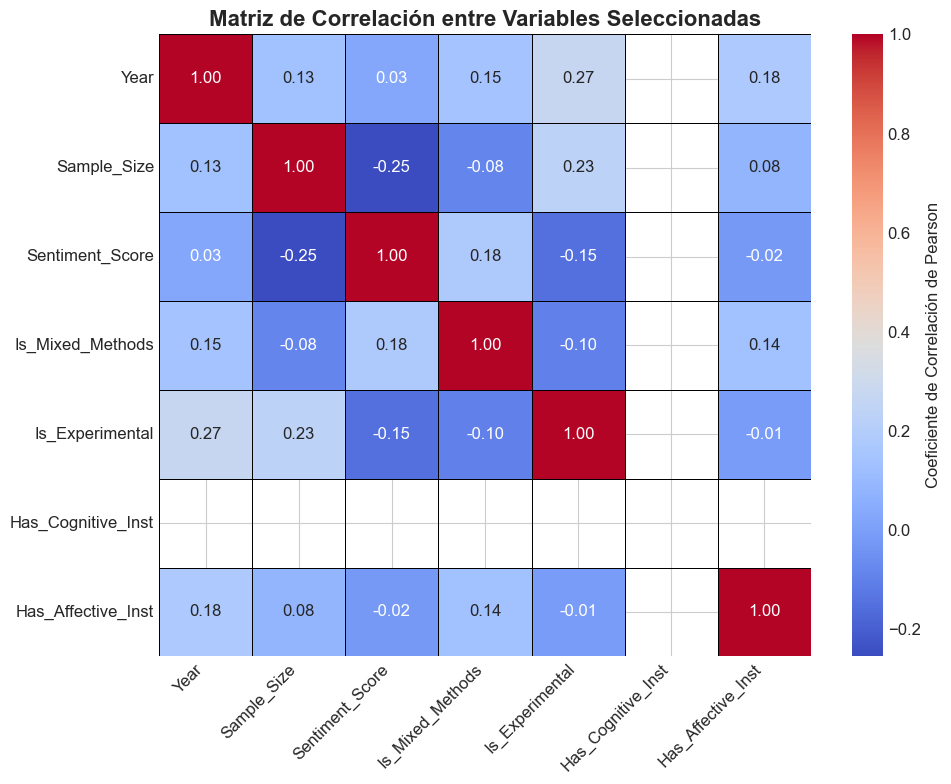


Pares con correlación absoluta > 0.3:
Year  Year   NaN
dtype: float64


In [14]:
# %% [markdown]
# ## 7. Análisis de Correlaciones y Relaciones
# Exploración de posibles relaciones entre variables numéricas y categóricas codificadas.

# %%
# === Preparación de Datos para Correlación ===
# Seleccionar variables relevantes y convertirlas a numéricas
corr_df = pd.DataFrame()

if 'Year' in df.columns:
    corr_df['Year'] = df['Year']
if 'Sample_Size_Numeric' in df.columns:
    # Imputar mediana para el análisis de correlación si hay faltantes
    median_sample = df['Sample_Size_Numeric'].median()
    corr_df['Sample_Size'] = df['Sample_Size_Numeric'].fillna(median_sample)
if 'Sentiment' in df.columns:
    # Mapear sentimiento a score numérico
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1, 'unknown': 0} # Asignar valor a unknown o excluirlo
    corr_df['Sentiment_Score'] = df['Sentiment'].map(sentiment_map).fillna(0) # Llenar NaNs si 'unknown' no está en el mapa

# Añadir variables categóricas codificadas (Ejemplos)
# Codificar presencia/ausencia de métodos o instrumentos
if 'Study Design' in df.columns:
     corr_df['Is_Mixed_Methods'] = df['Study Design'].str.lower().str.contains('mixed', na=False).astype(int)
     corr_df['Is_Experimental'] = df['Study Design'].str.lower().str.contains('experiment', na=False).astype(int) # Experimental o Quasi
if 'Cognitive Instruments' in df.columns:
    corr_df['Has_Cognitive_Inst'] = df['Cognitive Instruments'].notna().astype(int)
if 'Affective Instruments' in df.columns:
    corr_df['Has_Affective_Inst'] = df['Affective Instruments'].notna().astype(int)

# === Cálculo y Visualización de Matriz de Correlación ===
if len(corr_df.columns) > 1: # Necesitamos al menos 2 columnas para correlación
    correlation_matrix = corr_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                linewidths=.5, linecolor='black', cbar_kws={'label': 'Coeficiente de Correlación de Pearson'})
    plt.title('Matriz de Correlación entre Variables Seleccionadas', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    save_plot(plt.gcf(), 'matriz_correlacion.png')
    plt.show()

    # Imprimir correlaciones más fuertes (ejemplo)
    corr_threshold = 0.3
    strong_corrs = correlation_matrix[abs(correlation_matrix) > corr_threshold]
    strong_corrs = strong_corrs[strong_corrs != 1.0].unstack().sort_values(ascending=False).drop_duplicates()
    print(f"\nPares con correlación absoluta > {corr_threshold}:")
    if not strong_corrs.empty:
        print(strong_corrs)
    else:
        print("No se encontraron correlaciones fuertes (umbral > {corr_threshold}).")

else:
    print("No hay suficientes variables numéricas/codificadas para calcular la matriz de correlación.")



✓ Gráfico guardado en: output_plots\evolucion_temporal_muestra_sentimiento.png


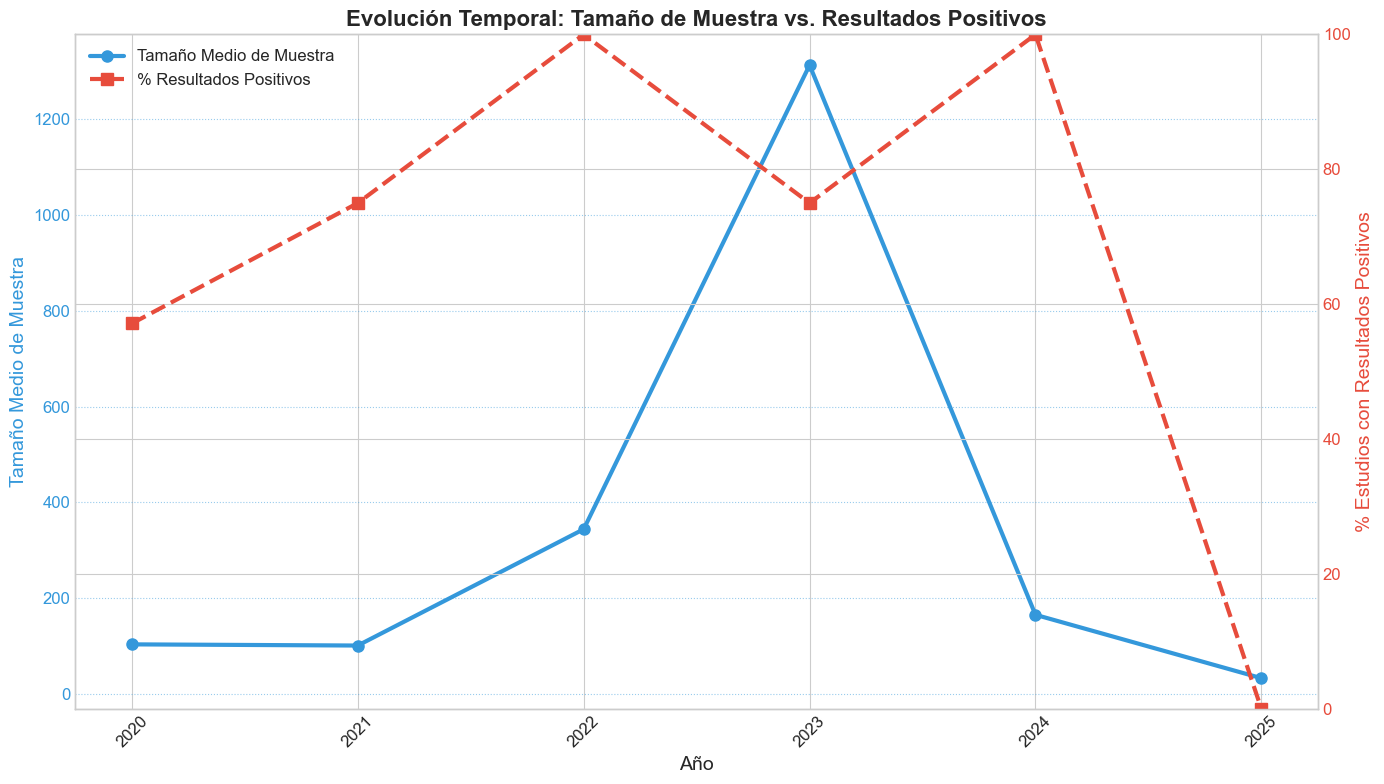

In [15]:
# %% [markdown]
# ## 8. Análisis Temporal Detallado
# Evolución de métricas clave a lo largo de los años.

# %%
if 'Year' in df.columns and 'Sample_Size_Numeric' in df.columns and 'Sentiment' in df.columns:
    # Agrupar por año y calcular métricas
    yearly_analysis = df.groupby('Year').agg(
        Mean_Sample_Size=('Sample_Size_Numeric', 'mean'),
        Median_Sample_Size=('Sample_Size_Numeric', 'median'),
        Positive_Sentiment_Rate=('Sentiment', lambda x: (x == 'positive').mean() * 100 if x.notna().any() else 0),
        Study_Count=('Year', 'size') # Contar estudios por año
    ).reset_index()

    # --- Gráfico de Doble Eje: Tamaño de Muestra y % Resultados Positivos ---
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Eje 1: Tamaño Medio de Muestra
    color1 = '#3498db'
    ax1.set_xlabel('Año', fontsize=14)
    ax1.set_ylabel('Tamaño Medio de Muestra', color=color1, fontsize=14)
    line1 = ax1.plot(yearly_analysis['Year'], yearly_analysis['Mean_Sample_Size'],
                     color=color1, marker='o', linewidth=3, markersize=8, linestyle='-',
                     label='Tamaño Medio de Muestra')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, axis='y', linestyle=':', color=color1, alpha=0.5) # Grid específico para el eje

    # Eje 2: Porcentaje de Resultados Positivos
    ax2 = ax1.twinx() # Instanciar un segundo eje que comparte el mismo eje X
    color2 = '#e74c3c'
    ax2.set_ylabel('% Estudios con Resultados Positivos', color=color2, fontsize=14)
    line2 = ax2.plot(yearly_analysis['Year'], yearly_analysis['Positive_Sentiment_Rate'],
                     color=color2, marker='s', linewidth=3, markersize=8, linestyle='--',
                     label='% Resultados Positivos')
    ax2.tick_params(axis='y', labelcolor=color2)
    # Establecer límites del eje Y para porcentaje (0 a 100)
    ax2.set_ylim(0, 100)

    # Título y Leyendas
    plt.title('Evolución Temporal: Tamaño de Muestra vs. Resultados Positivos', fontsize=16, fontweight='bold')
    # Combinar leyendas de ambos ejes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=12)

    # Ajustar ticks del eje X para mostrar todos los años si no son demasiados
    ax1.set_xticks(yearly_analysis['Year'])
    ax1.tick_params(axis='x', rotation=45)

    fig.tight_layout() # Ajustar layout para evitar solapamientos
    save_plot(fig, 'evolucion_temporal_muestra_sentimiento.png')
    plt.show()

else:
    print("No se puede realizar el análisis temporal detallado: Faltan columnas 'Year', 'Sample_Size_Numeric' o 'Sentiment'.")




Datos para PCA: 29 filas (después de eliminar NaNs).
✓ Gráfico guardado en: output_plots\pca_varianza_explicada.png


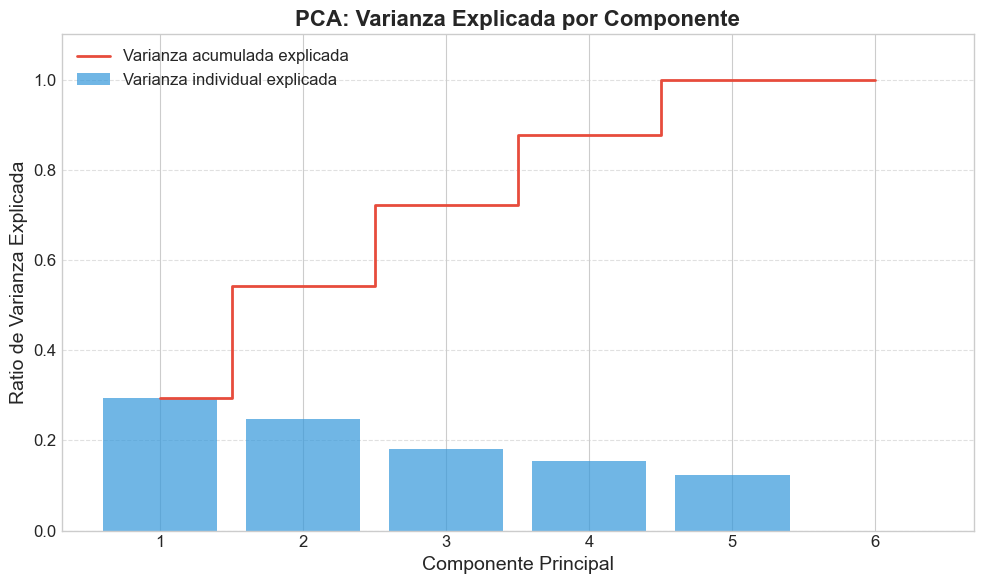

Varianza explicada por cada componente: [0.29495266 0.24648136 0.18013553 0.15444992 0.12398053 0.        ]
Varianza acumulada: [0.29495266 0.54143402 0.72156955 0.87601947 1.         1.        ]
✓ Gráfico guardado en: output_plots\pca_proyeccion_2d.png


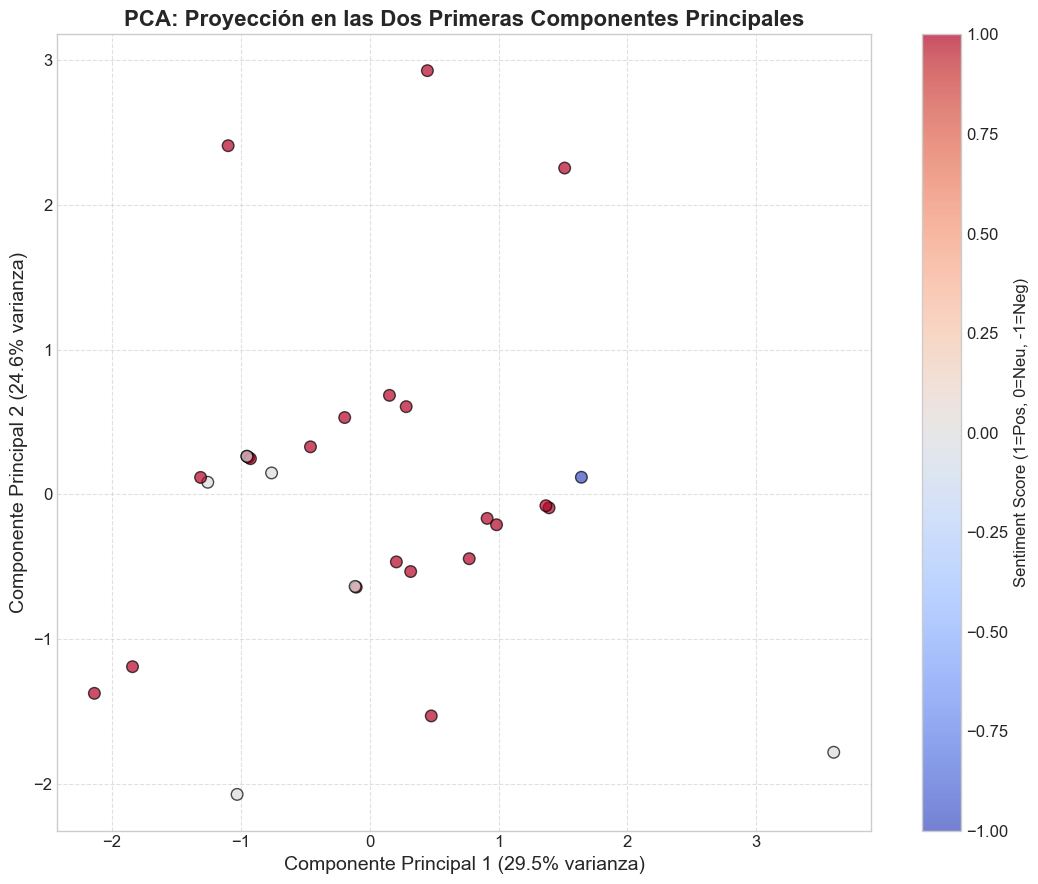

In [16]:
# %% [markdown]
# ## 9. Análisis Estadístico Avanzado (Opcional)
# Técnicas como PCA o modelos predictivos simples si los datos lo permiten.

# %% [markdown]
# ### 9.1 Análisis de Componentes Principales (PCA)
# Reducción de dimensionalidad para visualizar patrones en múltiples variables.

# %%
# === Preparación de Datos para PCA ===
# Seleccionar un subconjunto de variables numéricas/codificadas relevantes
# Usaremos las mismas que para la correlación, pero limpiando NaNs específicamente para PCA/Modelo
features_for_pca = ['Year', 'Sample_Size', 'Sentiment_Score', 'Is_Mixed_Methods', 'Is_Experimental', 'Has_Cognitive_Inst', 'Has_Affective_Inst']
# Verificar que las columnas existen en corr_df
existing_features = [f for f in features_for_pca if f in corr_df.columns]

if len(existing_features) > 2: # Necesitamos al menos 3 características para que PCA sea interesante
    features_df = corr_df[existing_features].copy()
    # Eliminar filas con CUALQUIER valor NaN en estas características
    features_clean = features_df.dropna()
    print(f"\nDatos para PCA: {features_clean.shape[0]} filas (después de eliminar NaNs).")

    if features_clean.shape[0] > features_clean.shape[1]: # Más muestras que características
        # Separar variable objetivo si se usa para colorear (ej. Sentiment_Score)
        pca_target = features_clean.get('Sentiment_Score', None) # Usar sentimiento para colorear si existe
        features_to_scale = features_clean.drop(columns=['Sentiment_Score'], errors='ignore')

        # Estandarizar los datos (media 0, desviación estándar 1)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_to_scale)

        # Aplicar PCA
        pca = PCA() # Instanciar PCA (se pueden especificar n_components)
        pca_result = pca.fit_transform(features_scaled)

        # === Visualización de Varianza Explicada ===
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.figure(figsize=(10, 6))
        n_components = len(explained_variance_ratio)
        plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.7,
                align='center', label='Varianza individual explicada', color='#3498db')
        plt.step(range(1, n_components + 1), cumulative_variance_ratio, where='mid',
                 label='Varianza acumulada explicada', color='#e74c3c', linewidth=2)

        plt.ylabel('Ratio de Varianza Explicada', fontsize=14)
        plt.xlabel('Componente Principal', fontsize=14)
        plt.title('PCA: Varianza Explicada por Componente', fontsize=16, fontweight='bold')
        plt.xticks(range(1, n_components + 1))
        plt.ylim(0, 1.1)
        plt.legend(loc='best')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        save_plot(plt.gcf(), 'pca_varianza_explicada.png')
        plt.show()

        print(f"Varianza explicada por cada componente: {explained_variance_ratio}")
        print(f"Varianza acumulada: {cumulative_variance_ratio}")

        # === Visualización de las Primeras Dos Componentes ===
        if pca_result.shape[1] >= 2: # Si tenemos al menos 2 componentes
            plt.figure(figsize=(11, 9))
            # Colorear por sentimiento si está disponible
            scatter_color = pca_target if pca_target is not None else None
            cmap_color = 'coolwarm' if pca_target is not None else 'viridis'

            scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                                  c=scatter_color, cmap=cmap_color, s=70, alpha=0.7, edgecolor='k')

            plt.xlabel(f'Componente Principal 1 ({explained_variance_ratio[0]:.1%} varianza)', fontsize=14)
            plt.ylabel(f'Componente Principal 2 ({explained_variance_ratio[1]:.1%} varianza)', fontsize=14)
            plt.title('PCA: Proyección en las Dos Primeras Componentes Principales', fontsize=16, fontweight='bold')
            plt.grid(linestyle='--', alpha=0.6)

            # Añadir barra de color si se coloreó por una variable continua/categórica mapeada
            if scatter_color is not None:
                cbar = plt.colorbar(scatter)
                cbar.set_label('Sentiment Score (1=Pos, 0=Neu, -1=Neg)', fontsize=12) # Ajustar etiqueta

            plt.tight_layout()
            save_plot(plt.gcf(), 'pca_proyeccion_2d.png')
            plt.show()
        else:
            print("No hay suficientes componentes principales (>=2) para generar el gráfico 2D.")
    else:
        print("No hay suficientes datos limpios o características para realizar PCA de manera significativa.")
else:
    print("No se puede realizar PCA: No hay suficientes características seleccionadas o datos en `corr_df`.")




Importancia de Características (Coeficientes Regresión Logística):
              Feature  Coefficient
2    Is_Mixed_Methods     0.602137
1         Sample_Size    -0.543281
0                Year     0.502360
3     Is_Experimental    -0.193115
5  Has_Affective_Inst    -0.086404
4  Has_Cognitive_Inst     0.000000
✓ Gráfico guardado en: output_plots\importancia_caracteristicas_logreg.png


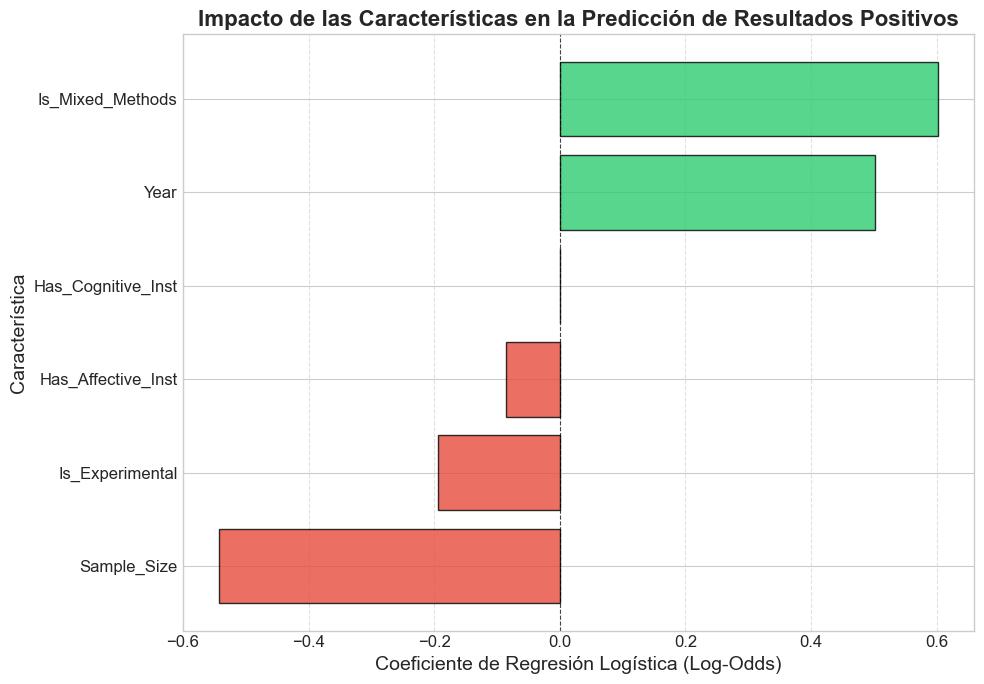

In [17]:
# %% [markdown]
# ### 9.2 Modelo Predictivo Simple (Ej. Regresión Logística)
# Intento de predecir resultados positivos basados en otras características.

# %%
# Usaremos los mismos datos limpios que para PCA
if 'features_clean' in locals() and 'Sentiment_Score' in features_clean.columns and features_clean.shape[0] > 20: # Necesitamos suficientes datos

    # Definir variable objetivo (binaria: positivo vs no positivo)
    features_clean['Positive_Result'] = (features_clean['Sentiment_Score'] == 1).astype(int)
    y = features_clean['Positive_Result']
    X = features_clean.drop(columns=['Sentiment_Score', 'Positive_Result'], errors='ignore') # Usar características originales (no escaladas) o escaladas

    # Verificar si X tiene columnas antes de proceder
    if not X.empty and not y.empty:
        # Estandarizar características para regresión logística
        scaler_logreg = StandardScaler()
        X_scaled = scaler_logreg.fit_transform(X)

        # Entrenar modelo de Regresión Logística
        # NOTA: Sin división train/test, esto evalúa el ajuste al *total* de los datos, no la generalización.
        # Para evaluación real, se necesitaría `train_test_split` de scikit-learn.
        try:
            model = LogisticRegression(random_state=42, class_weight='balanced') # class_weight para datos desbalanceados
            model.fit(X_scaled, y)

            # === Importancia de Características (Coeficientes) ===
            coefficients = model.coef_[0]
            feature_importance = pd.DataFrame({
                'Feature': X.columns,
                'Coefficient': coefficients
            })
            # Ordenar por valor absoluto del coeficiente para ver impacto
            feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
            feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False) # De mayor a menor impacto

            print("\nImportancia de Características (Coeficientes Regresión Logística):")
            print(feature_importance[['Feature', 'Coefficient']])

            # Visualizar Coeficientes
            plt.figure(figsize=(10, 7))
            # Colores según signo del coeficiente
            colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in feature_importance['Coefficient']]
            # Graficar ordenado por nombre para consistencia o por importancia
            feat_imp_sorted = feature_importance.sort_values('Coefficient') # Ordenar por valor para el gráfico
            colors_sorted = ['#2ecc71' if c > 0 else '#e74c3c' for c in feat_imp_sorted['Coefficient']]

            plt.barh(feat_imp_sorted['Feature'], feat_imp_sorted['Coefficient'], color=colors_sorted, alpha=0.8, edgecolor='black')
            plt.xlabel('Coeficiente de Regresión Logística (Log-Odds)', fontsize=14)
            plt.ylabel('Característica', fontsize=14)
            plt.title('Impacto de las Características en la Predicción de Resultados Positivos', fontsize=16, fontweight='bold')
            plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.7) # Línea en cero
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            plt.tight_layout()
            save_plot(plt.gcf(), 'importancia_caracteristicas_logreg.png')
            plt.show()

        except Exception as e:
             print(f"Error al entrenar o analizar el modelo de Regresión Logística: {e}")

    else:
        print("No se puede entrenar el modelo: No hay suficientes características (X) o variable objetivo (y).")
else:
    print("No se puede construir el modelo predictivo: Datos insuficientes o falta la variable 'Sentiment_Score'.")



In [18]:
# %% [markdown]
# ## 10. Resumen Ejecutivo y Exportación de Resultados

# %%
# === Generación del Resumen Ejecutivo (Texto) ===
print("\n" + "="*60)
print(" RESUMEN EJECUTIVO DEL ANÁLISIS ESTADÍSTICO")
print("="*60)

# Recopilar métricas clave (asegurarse de que las variables existan)
total_studies = len(df)
period_start = df['Year'].min() if 'Year' in df.columns else 'N/A'
period_end = df['Year'].max() if 'Year' in df.columns else 'N/A'
num_countries = df['Country'].nunique() if 'Country' in df.columns else 'N/A'
mean_sample = f"{df['Sample_Size_Numeric'].mean():.0f}" if 'Sample_Size_Numeric' in df.columns and df['Sample_Size_Numeric'].notna().any() else 'N/A'
median_sample = f"{df['Sample_Size_Numeric'].median():.0f}" if 'Sample_Size_Numeric' in df.columns and df['Sample_Size_Numeric'].notna().any() else 'N/A'
perc_positive = f"{(df['Sentiment'] == 'positive').mean()*100:.1f}%" if 'Sentiment' in df.columns and 'positive' in df['Sentiment'].unique() else 'N/A'
most_common_design = max(design_counts, key=design_counts.get) if 'design_counts' in locals() and design_counts else 'N/A'
peak_year = df['Year'].value_counts().idxmax() if 'Year' in df.columns else 'N/A'
top_country = country_counts.index[0] if 'country_counts' in locals() and not country_counts.empty else 'N/A'

# Calcular herramienta más común si existe tool_counts
if 'tool_counts' in locals() and not tool_counts.empty:
    most_common_tool = tool_counts.index[0]
    tool_freq = tool_counts.iloc[0]
    tool_perc = (tool_freq / len(df)) * 100 # O sobre el número de menciones totales?
    most_common_tool_str = f"{most_common_tool} (mencionado en ~{tool_perc:.0f}% de estudios)"
else:
    most_common_tool_str = 'N/A'

# Construir el texto del resumen
summary_text = f"""
1.  **Alcance de la Revisión:**
    - Estudios Analizados: {total_studies}
    - Período Cubierto: {period_start} - {period_end}
    - Diversidad Geográfica: {num_countries} países representados (Top: {top_country})
    - Tamaño de Muestra Promedio (Mediana): {mean_sample} ({median_sample}) participantes

2.  **Hallazgos Clave:**
    - Tendencia de Resultados: {perc_positive} de los estudios reportaron resultados predominantemente positivos.
    - Diseño Metodológico Principal: El diseño más frecuente fue '{most_common_design}'.
    - Enfoque Tecnológico: La categoría de herramienta digital más estudiada fue '{most_common_tool_str}'.

3.  **Tendencias Notables:**
    - Pico de Publicaciones: El año con mayor número de estudios fue {peak_year}.
    - Evolución Temporal: [Mencionar alguna tendencia observada en el gráfico temporal, ej., crecimiento en tamaño de muestra o cambio en % positivos].

4.  **Factores Potencialmente Relevantes (Exploratorio):**
    - [Mencionar alguna correlación interesante o resultado del modelo si se realizó, ej., 'Estudios con métodos mixtos mostraron una ligera tendencia a reportar resultados positivos.' o 'El tamaño de la muestra no parece correlacionarse fuertemente con el resultado reportado.']

5.  **Consideraciones:**
    - Limitaciones: Basado en análisis de texto simple y datos disponibles. La calidad y detalle de los reportes originales varían.
    - Futuras Líneas: Análisis más profundos podrían incluir meta-análisis de tamaños de efecto si los datos lo permiten.
"""
print(summary_text)

# === Exportación de Resultados a CSV ===
print("\n" + "="*60)
print(" EXPORTANDO RESULTADOS A ARCHIVOS CSV")
print("="*60)

# 1. Resumen de Métricas Clave
results_summary_data = {
    'Métrica': [
        'Total de Estudios Analizados', 'Período Inicio', 'Período Fin',
        'Número de Países Únicos', 'País Más Representado',
        'Tamaño Medio Muestra', 'Tamaño Mediana Muestra',
        '% Estudios con Resultados Positivos', 'Diseño Más Común',
        'Año Pico de Publicación', 'Herramienta Más Común (Categoría)'
    ],
    'Valor': [
        total_studies, period_start, period_end,
        num_countries, top_country,
        mean_sample, median_sample,
        perc_positive, most_common_design,
        peak_year, most_common_tool_str.split(' (')[0] # Solo el nombre
    ]
}
results_summary_df = pd.DataFrame(results_summary_data)
summary_csv_path = os.path.join(OUTPUT_DIR, 'resumen_analisis_metricas.csv')
try:
    results_summary_df.to_csv(summary_csv_path, index=False, encoding='utf-8-sig') # utf-8-sig para mejor compatibilidad Excel
    print(f"✓ Resumen de métricas guardado en: {summary_csv_path}")
except Exception as e:
    print(f"Error al guardar resumen de métricas: {e}")

# 2. Datos Agregados por Año (si existen)
if 'yearly_analysis' in locals():
    yearly_csv_path = os.path.join(OUTPUT_DIR, 'estadisticas_anuales_agregadas.csv')
    try:
        yearly_analysis.to_csv(yearly_csv_path, index=False, encoding='utf-8-sig')
        print(f"✓ Estadísticas anuales guardadas en: {yearly_csv_path}")
    except Exception as e:
        print(f"Error al guardar estadísticas anuales: {e}")

# 3. Frecuencias (Ejemplos: países, herramientas)
if 'country_counts' in locals():
    country_counts.to_csv(os.path.join(OUTPUT_DIR, 'frecuencia_paises.csv'), header=['count'], encoding='utf-8-sig')
    print("✓ Frecuencia de países guardada.")
if 'tool_counts' in locals():
    tool_counts.to_csv(os.path.join(OUTPUT_DIR, 'frecuencia_herramientas.csv'), header=['count'], encoding='utf-8-sig')
    print("✓ Frecuencia de tipos de herramientas guardada.")


# 4. DataFrame Procesado Completo (Opcional, puede ser grande)
# processed_df_path = os.path.join(OUTPUT_DIR, 'dataset_procesado_completo.csv')
# try:
#     df.to_csv(processed_df_path, index=False, encoding='utf-8-sig')
#     print(f"✓ Dataset procesado completo guardado en: {processed_df_path}")
# except Exception as e:
#     print(f"Error al guardar dataset procesado: {e}")


print("\n✓ Análisis y exportación completados.")



 RESUMEN EJECUTIVO DEL ANÁLISIS ESTADÍSTICO

1.  **Alcance de la Revisión:**
    - Estudios Analizados: 29
    - Período Cubierto: 2020 - 2025
    - Diversidad Geográfica: 21 países representados (Top: Indonesia)
    - Tamaño de Muestra Promedio (Mediana): 299 (116) participantes

2.  **Hallazgos Clave:**
    - Tendencia de Resultados: 75.9% de los estudios reportaron resultados predominantemente positivos.
    - Diseño Metodológico Principal: El diseño más frecuente fue 'Experimental'.
    - Enfoque Tecnológico: La categoría de herramienta digital más estudiada fue 'AR/VR/3D (mencionado en ~76% de estudios)'.

3.  **Tendencias Notables:**
    - Pico de Publicaciones: El año con mayor número de estudios fue 2021.
    - Evolución Temporal: [Mencionar alguna tendencia observada en el gráfico temporal, ej., crecimiento en tamaño de muestra o cambio en % positivos].

4.  **Factores Potencialmente Relevantes (Exploratorio):**
    - [Mencionar alguna correlación interesante o resultado del 